In [1]:
pip install keras-tuner --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import shutil
import pathlib
import shutil
import tensorflow as tf
import keras
import keras_tuner as kt

#models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from keras.utils import  Sequence


#preproces
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications import EfficientNetB0


from imblearn.over_sampling import SMOTE



from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler



from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

from collections import Counter




# Прогрузка Данных

In [3]:
imgs = glob(r'/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/*/*')
labels = [el.split('/')[5] for el in imgs ]

## Визуализация Классов

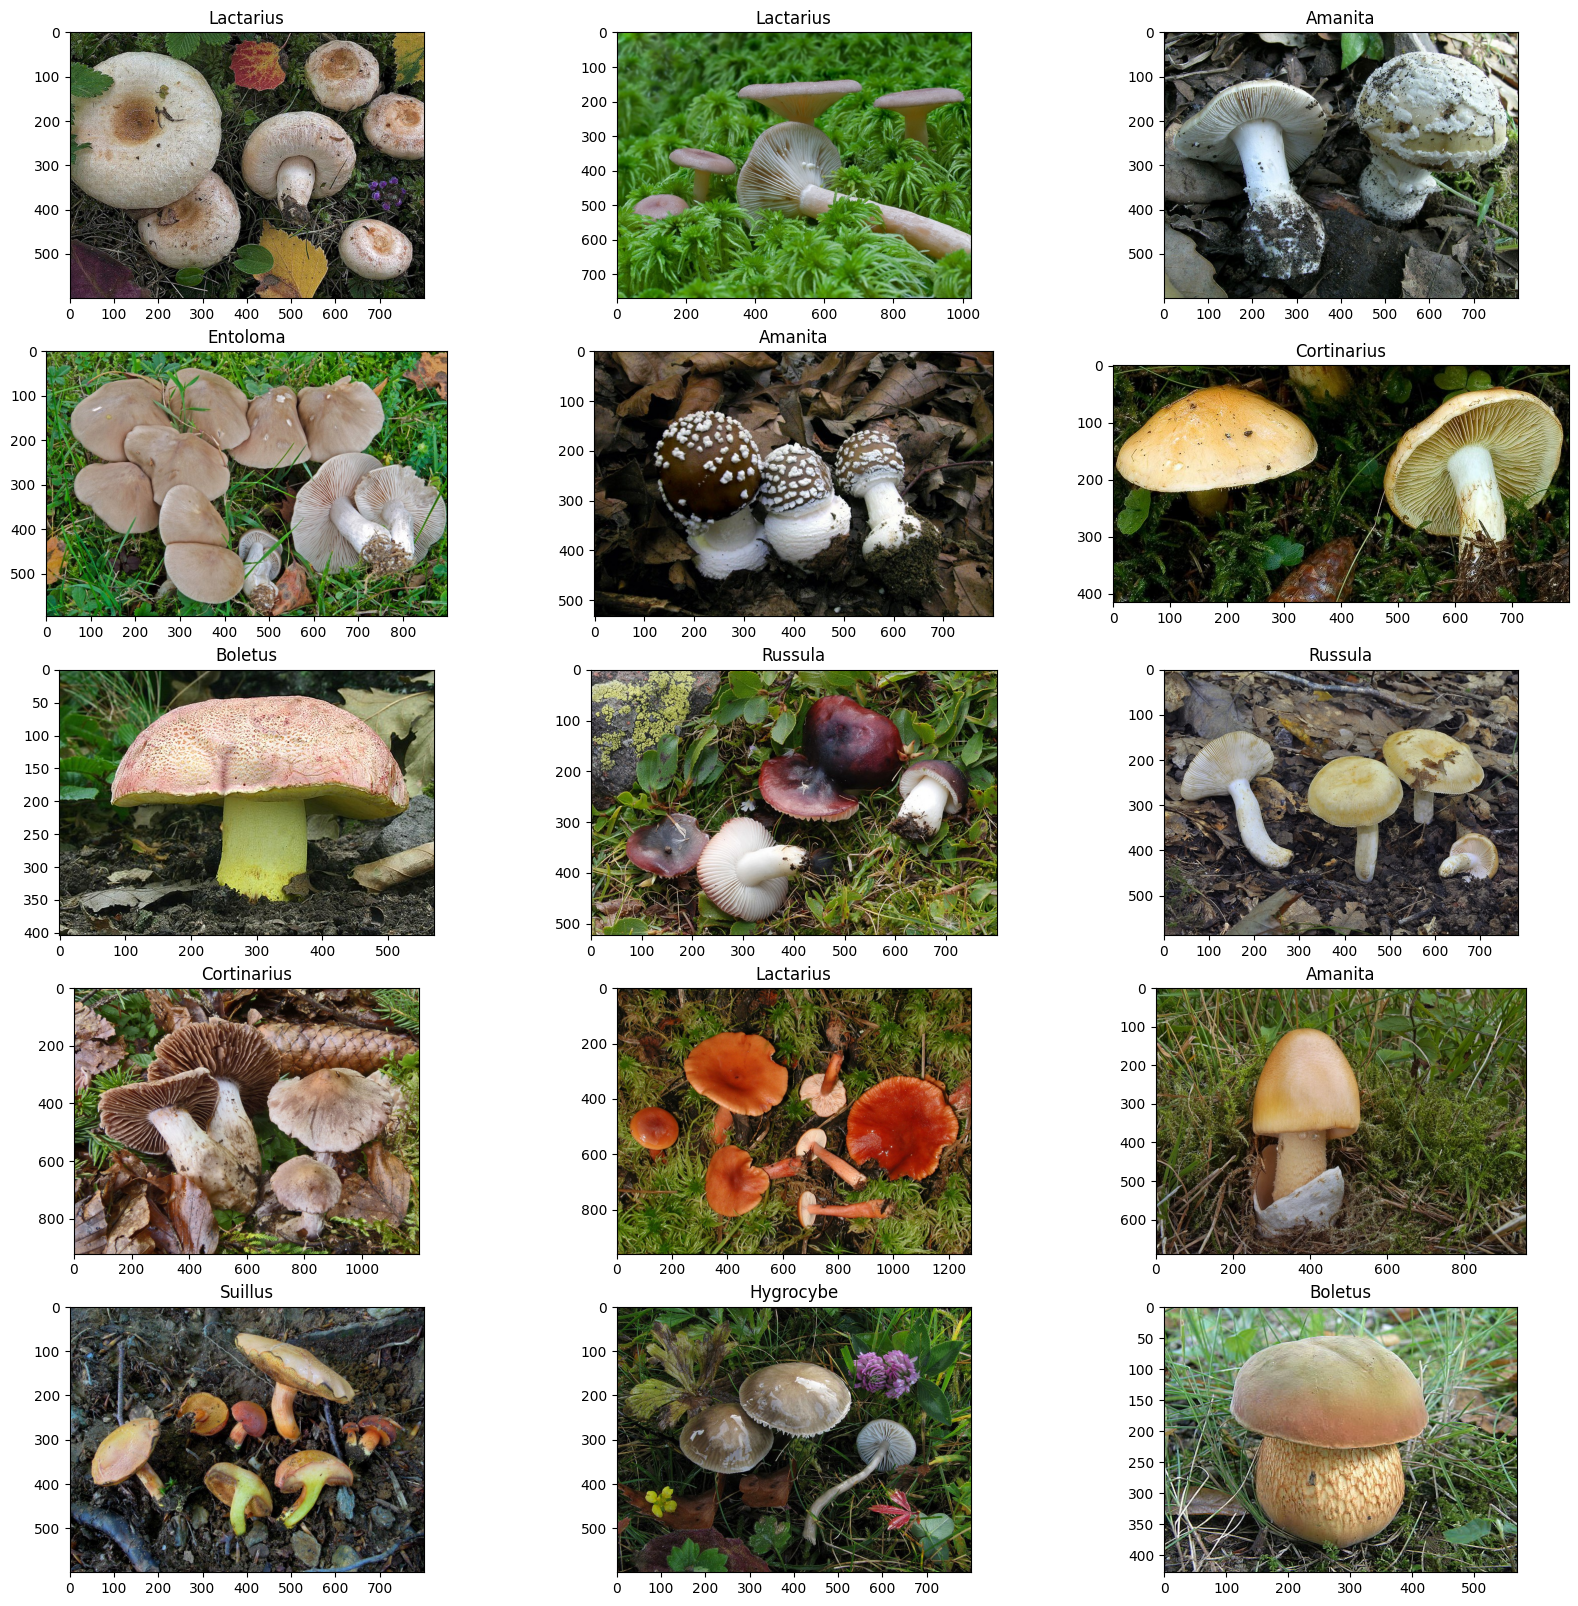

In [4]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
fig.subplots_adjust()
im_list = np.random.choice(imgs, 15)
for axi, im in zip( ax.flat, im_list):
    axi.set_title(im.split('/')[5],)
    axi.imshow(plt.imread(im), )
   

## Распределеник по классам

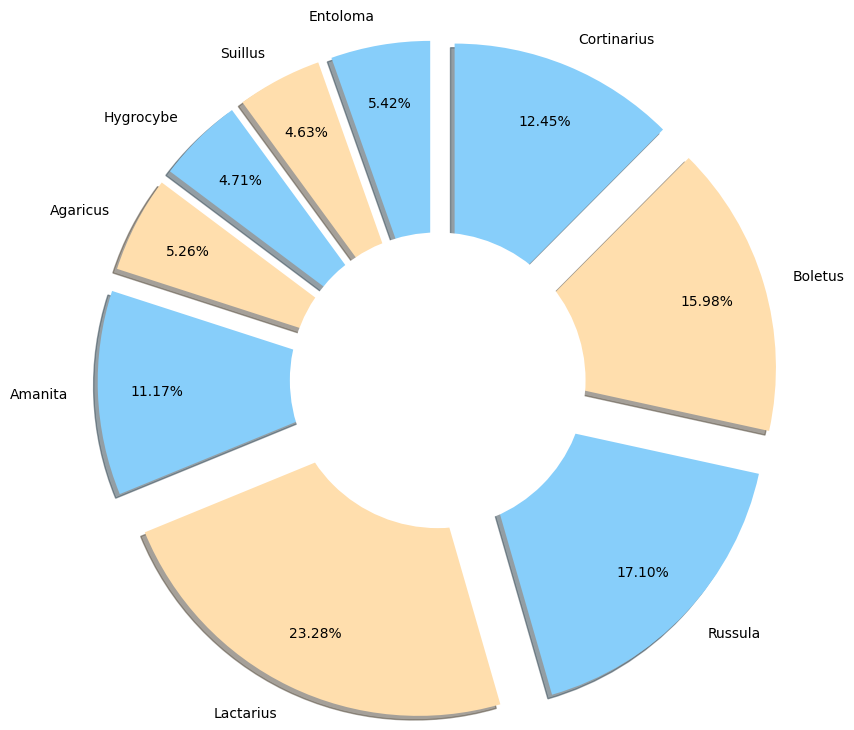

In [5]:
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
tab = {'lightskyblue': '#87CEFA', 'navajowhite': '#FFDEAD'}

plt.pie.DonutSize=9
plt.pie(distribution_dict.values(), labels=distribution_dict.keys(),radius=2, colors=tab, shadow=True, startangle=90, autopct='%1.2f%%',
       pctdistance=0.80, explode=[0.3 for el in range(9)])

hole = plt.Circle((0, 0), 1.0, facecolor='white')
plt.gcf().gca().add_artist(hole)
 
plt.show()

## Для подбора условий возьмем 20 % данных

In [6]:
X, X_, y, y_ = train_test_split(imgs, labels, test_size=0.8, stratify=labels, random_state=44)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [10]:
train  = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test  = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X       1073 non-null   object
 1   y       1073 non-null   object
dtypes: object(2)
memory usage: 16.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X       269 non-null    object
 1   y       269 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


(None, None)

In [11]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        brightness_range=(1.0, 0.8))
datagen_valid = ImageDataGenerator()

In [12]:
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y",)
test_gen = datagen_valid.flow_from_dataframe(test, x_col='X', y_col="y",)

Found 1073 validated image filenames belonging to 9 classes.
Found 269 validated image filenames belonging to 9 classes.


In [16]:
def build_model(hp, num_classes=9, shape=(256,256,3)):
    inputs = layers.Input(shape=shape)
    model = EfficientNetB0(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        #classes=num_classes,
        classifier_activation='softmax')
    
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=0.25,
        gamma=2.0,
        from_logits=False)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam','nadam'])
    if hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=hp_learning_rate)
    else:
        raise
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [17]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5, seed=123,)


Reloading Tuner from ./untitled_project/tuner0.json


In [18]:
tuner.search(train_gen, epochs=10, validation_data=test_gen)

Trial 5 Complete [00h 04m 25s]
val_loss: 0.14445486664772034

Best val_loss So Far: 0.13191130757331848
Total elapsed time: 00h 15m 47s


### Подобранные Гиперпараметры

In [19]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'learning_rate': 0.001, 'optimizer': 'adam'}